# Выбор локации для скважины

**ЦЕЛЬ ПРОЕКТА:** На основе данных геологоразведки выбрать район добычи нефти

На основе предоставленных данных необходимо построить модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль, и проанализировать возможную прибыль и риски техникой *Bootstrap.*

**ОПИСАНИЕ ДАННЫХ**  

Данные геологоразведки трёх регионов находятся в разных файлах.  

`id` — уникальный идентификатор скважины;  
`f0`, `f1`, `f2` — три признака точек (значимых признаков);  
`product` — объём запасов в скважине (тыс. баррелей).


## Загрузка и подготовка данных

In [1]:
# Импорт библиотек:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from numpy.random import RandomState 

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from scipy import stats as st

import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.float_format', '{:,.2f}'.format)
state = RandomState(12345)

In [2]:
# загрузка данных
df1 = pd.read_csv('/datasets/geo_data_0.csv')
df2 = pd.read_csv('/datasets/geo_data_1.csv')
df3 = pd.read_csv('/datasets/geo_data_2.csv')

In [3]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [4]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [5]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


Пропусков в данных нет

In [6]:
df1.head()

,id,f0,f1,f2,product
0,txEyH,0.71,-0.50,1.22,105.28
1,2acmU,1.33,-0.34,4.37,73.04
2,409Wp,1.02,0.15,1.42,85.27
3,iJLyR,-0.03,0.14,2.98,168.62
4,Xdl7t,1.99,0.16,4.75,154.04


In [7]:
df2.head()

,id,f0,f1,f2,product
0,kBEdx,-15.00,-8.28,-0.01,3.18
1,62mP7,14.27,-3.48,1.00,26.95
2,vyE1P,6.26,-5.95,5.00,134.77
3,KcrkZ,-13.08,-11.51,5.00,137.95
4,AHL4O,12.70,-8.15,5.00,134.77


In [8]:
df3.head()

,id,f0,f1,f2,product
0,fwXo0,-1.15,0.96,-0.83,27.76
1,WJtFt,0.26,0.27,-2.53,56.07
2,ovLUW,0.19,0.29,-5.59,62.87
3,q6cA6,2.24,-0.55,0.93,114.57
4,WPMUX,-0.52,1.72,5.90,149.60


In [9]:
# Проверим данные на наличие дубликатов
df1.duplicated().sum()

0

In [10]:
df2.duplicated().sum()

0

In [11]:
df3.duplicated().sum()

0

In [12]:
# проверим данные на уникальность
df1.nunique()

id          99990
f0         100000
f1         100000
f2         100000
product    100000
dtype: int64

In [13]:
df2.nunique()

id          99996
f0         100000
f1         100000
f2         100000
product        12
dtype: int64

In [14]:
df3.nunique()

id          99996
f0         100000
f1         100000
f2         100000
product    100000
dtype: int64

Есть несколько не уникальных id, но признаки у них разные. Мы не знаем значений признаков, возможно, проводились разные измерения в одних и тех же скважинах. Дубликатов в данных нет.

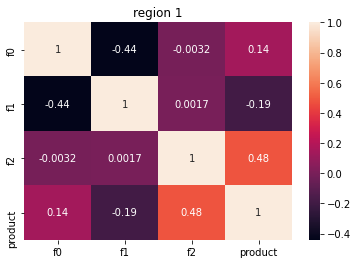

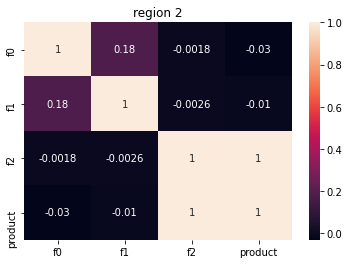

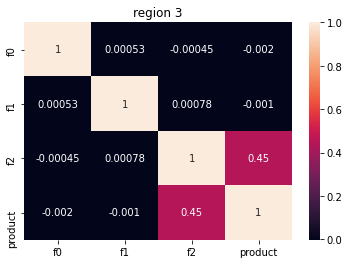

In [15]:
# Проверим данные на корреляцию
regions = [df1, df2, df3] 
for i in range(len(regions)):
    ax = plt.axes()
    sns.heatmap(regions[i].corr(), annot = True)
    ax.set_title('region ' + str(i+1))
    plt.show()

По тепловым диаграммам мы обнаружили высокую корреляцию между признаком f2 и целевым признаком в регионе №2, что говорит о наличии линейной функциональной зависимости. 

ВЫВОДЫ:  
Данные не содеражт ни пропусков, ни дубликатов, поэтому предобработка не нужна. Все датафреймы одинакового размера, что облегчит нам дальнейшую работу. В данных второго региона существует очень высокая корреляция между признаком f2 и продуктом (product), среднеквадратическая ошибка в данном регионе должна быть меньше единицы.

In [16]:
# проверим данные на мультиколлинеарность
#sns.pairplot(data=df1, hue = 'product')
#sns.pairplot(data=df2, hue = 'product')
#sns.pairplot(data=df3, hue = 'product')

Проверку на мультиколлинеарность закомментировала из-за очень длительного выполнения. Оставляю только гистограммы

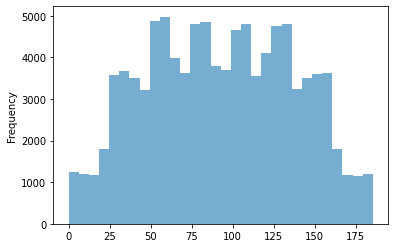

In [17]:
# распределение целевого признака в первом регионе
df1['product'].plot(kind='hist', bins=30, alpha=0.6)
plt.show()

В первом регионе распределение данных столбца "product" имеет 4 больших пика и два поменьше. Можно предположить, что в районе сбора данные есть несколько тысяч перспективных скважин. 


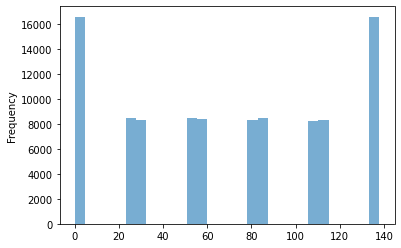

In [18]:
# распределение целевого признака во втором регионе
df2['product'].plot(kind='hist', bins=30, alpha=0.6)
plt.show()

По предварительному визуальному осмотру можно предположить, что в регионе
есть несколько тысяч перспективных скважин с мощностью более 130 тыс. баррелей.

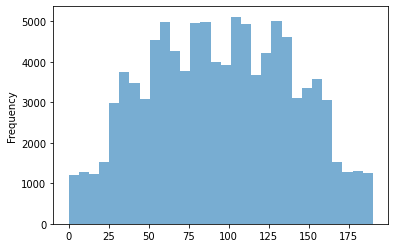

In [19]:
# распределение целевого признака в третьем регионе
df3['product'].plot(kind='hist', bins=30, alpha=0.6)
plt.show()

По предварительному визуальному осмотру можно предположить, что в регионе есть несколько тысяч перспективных скважин. Распределение целевого признака в первом и третьем регионах похожи.

## Обучение и проверка модели

#### Обучим модель и сделаем предсказания на валидационной выборке

In [20]:
def lin_reg_predict(df):
    # разобьём датасет на обучающую и целевую выборки
    features = df.drop(['id', 'product'], axis=1)
    target = df['product']
    # разделим обучающую и целевую выборки на тренировочную и валидационную 
    features_train, features_valid, target_train, target_valid = train_test_split(features, target, 
                                           test_size=0.25, random_state=state)
    
    # обучим модель методом линейной регрессии
    model = LinearRegression()
    model.fit(features_train, target_train)
    predictions = model.predict(features_valid)
    
    # посчитаем rmse и среднюю предсказанного сырья
    mse = mean_squared_error(target_valid, predictions)
    rmse = mse**0.5
    mean = predictions.mean()
    return mean, rmse, target_valid, predictions

#### Найдем средний запас предсказанного сырья для каждого региона и RMSE модели

In [21]:
mean, rmse, target_valid, predictions = lin_reg_predict(df1)
print('Среднее:', mean, 'RMSE:', rmse)

Среднее: 92.59256778438035 RMSE: 37.5794217150813


In [22]:
mean, rmse, target_valid, predictions = lin_reg_predict(df2)
print('Среднее:', mean, 'RMSE:', rmse)

Среднее: 68.76995145799754 RMSE: 0.889736773768065


In [23]:
mean, rmse, target_valid, predictions = lin_reg_predict(df3)
print('Среднее:', mean, 'RMSE:', rmse)

Среднее: 95.087528122523 RMSE: 39.958042459521614


ВЫВОДЫ:  
В регионе №1. Средний запас предсказанного сырья: 92.593 тыс.баррелей, RMSE = 37.5794;  
В регионе №2. Средний запас предсказанного сырья: 68.770 тыс.баррелей, RMSE = 0.8897;  
В регионе №3. Средний запас предсказанного сырья: 95.088 тыс.баррелей, RMSE = 39.9580 

## Подготовка к расчёту прибыли

ВВОДНЫЕ ДАННЫЕ ДЛЯ РСЧЕТА ПРИБЫЛИ:  

•	При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.  
•	Бюджет на разработку скважин в регионе — 10 млрд рублей.  
•	При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей. 

In [24]:
# Сохраняем ключевые значения для расчетов
reg_budget = 10_000_000_000 # Бюджет на разработку скважин в регионе
one_barrel_income = 450  # Доход с одного барреля сырья 
income_per_unit = 450_000 # Доход с каждой единицы продукта 
wells_count = 200 # Количество лучших шахт для расчета прибыли

In [25]:
# рассчитаем цену одной скважины
price_one_well = reg_budget / wells_count 
price_one_well

50000000.0

In [26]:
# Рассчитываем достаточный объём сырья для безубыточной разработки новой скважины
reg_development = reg_budget/income_per_unit
sufficient_volume = reg_development / wells_count
round(sufficient_volume,2)

111.11

ВЫВОДЫ:  
При существующем уровне цен в 450 тыс.руб. за тыс.баррелей, безубыточная добыча начинается со скважин с запасом в 111,11 тыс.баррелей. По предсказаниям в среднем такого объема нет ни в одном регионе.  

Средний предсказанный запас сырья в регионе 1 меньше объёма достаточного для безубыточной разработки на 16.66%
Средний предсказанный запас сырья в регионе 2 меньше объёма достаточного для безубыточной разработки на 38.01%
Средний предсказанный запас сырья в регионе 3 меньше объёма достаточного для безубыточной разработки на 14.42% 

Ближе всего к необходимому количеству предсказанные запасы в регионе №3, меньше всего предсказанных запасов в регионе №2.

## Расчёт прибыли и рисков 

#### Функция для расчета прибыли по выбранным скважинам и предсказаниям модели

In [27]:
def revenue(target, predictions, count):
    # рассчитаем прибыль от 200 скважин
    target = target.reset_index(drop=True)
    predictions = pd.Series(predictions).sort_values(ascending=False)[:count].index
    selected = target[predictions]
    revenue = selected.sum() * income_per_unit - reg_budget
    return round(revenue, 2)

In [28]:
mean, rmse, target_valid, predictions = lin_reg_predict(df1)
revenue(target_valid, predictions, wells_count)

3333004211.95

In [29]:
mean, rmse, target_valid, predictions = lin_reg_predict(df2)
revenue(target_valid, predictions, wells_count)

2415086696.68

In [30]:
mean, rmse, target_valid, predictions = lin_reg_predict(df3)
revenue(target_valid, predictions, wells_count)

2697494877.9

ВЫВОДЫ:  
Прибыль для полученного объёма сырья региона №1: 3.3948 млрд.руб.  
Прибыль для полученного объёма сырья региона №2: 2.4151 млрд.руб.  
Прибыль для полученного объёма сырья региона №3: 2.6975 млрд.руб.  

## Расчёт прибыли и рисков

In [31]:
def boot(target, predictions):
    state = np.random.RandomState(12345)
    values = []
    for i in range(1000):
        target = target.reset_index(drop=True)
        target_subsample = target.sample(n=500, random_state=state, replace=True)
        probs_subsample = predictions[target_subsample.index]
        values.append(revenue(target_subsample, probs_subsample, wells_count))

    values = pd.Series(values)
    mean = values.mean()
    risk = (values < 0).mean()
    
    lower = values.quantile(0.025)
    upper = values.quantile(0.975)
    quantile_interval = (lower, upper)
    
    return round(mean,2), round(risk*100, 2), quantile_interval

In [32]:
mean, rmse, target_valid, predictions = lin_reg_predict(df1)
mean, risk, quantile_interval = boot(target_valid, predictions) 
print('Средняя прибыль первого региона:', mean, 'Риск убытков:', risk, 'Доверительный интервал:', quantile_interval)

Средняя прибыль первого региона: 437996403.61 Риск убытков: 4.5 Доверительный интервал: (-69611413.64975, 983858547.1804999)


In [33]:
mean, rmse, target_valid, predictions = lin_reg_predict(df2)
mean, risk, quantile_interval = boot(target_valid, predictions) 
print('Средняя прибыль первого региона:', mean, 'Риск убытков:', risk, 'Доверительный интервал:', quantile_interval)

Средняя прибыль первого региона: 456746346.71 Риск убытков: 1.5 Доверительный интервал: (63169500.666, 864622125.7844999)


In [34]:
mean, rmse, target_valid, predictions = lin_reg_predict(df3)
mean, risk, quantile_interval = boot(target_valid, predictions) 
print('Средняя прибыль первого региона:', mean, 'Риск убытков:', risk, 'Доверительный интервал:', quantile_interval)

Средняя прибыль первого региона: 401652865.59 Риск убытков: 8.1 Доверительный интервал: (-156895913.91474998, 917469491.1682498)


ВЫВОДЫ: 

* Регион №1:  
Средняя прибыль 437996403.61  
Доверительный интервал (-69611413.64975, 983858547.1804999)  
Риск убытков: 4.5%

* Регион №2:  
Средняя прибыль 456746346.71  
Доверительный интервал (63169500.666, 864622125.7844999)  
Риск убытков: 1.5%

* Регион №3:  
Средняя прибыль 401652865.59  
Доверительный интервал (-156895913.91474998, 917469491.1682498)  
Риск убытков: 8.1%

**ОБЩИЙ ВЫВОД**  

В результате проведенного исследования имеющихся данных по трем регионам методом линейной регрессии для каждого региона мы сравнили средний запас редсказанного сырья и RMSE модели. Средний запас предсказанного сырья во всех регионах ниже достаточного для точки безубыточности. Из этого можно сделать вывод, что у в каждом регионе будут риски убытков.  
Наибольшее значение прибыли для полученного объёма сырья в 3.4337 млрд.руб. получено в регионе №1.  
Согласно прогнозам, сделанным с помощью техники Bootstrap, в регионе №2 самые высокие показатели средней прибыли и 95%-ного доверительного интервала. Также в регионе №2 самый низкий риск убытков. Согласно стратегии risk avoidance наиболее прибыльным будет разработка месторождений в регионе №2.